# Introduction

This notebook creates the charts corresponding to experiments on auxiliary learning and the associated blog post. Please see the corresponding [repository](https://github.com/vivien000/auxiliary-learning).

In [0]:
!pip3 install -q seaborn==0.9.0

**When using running Colab, the runtime needs to be restarted at this point to take into account Seaborn's new version (Colab's current version of Seaborn is 0.7.1).**

In [0]:
!git clone -q https://github.com/vivien000/auxiliary-learning.git
%cd -q auxiliary-learning

In [0]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("tab10", n_colors=10)
sns.set_palette([palette[1], palette[0], palette[2], palette[3], palette[4]])

matplotlib.rcParams['figure.figsize'] = 8, 6

In [0]:
def chart_celeba(df, hue='mode', hue_order=None, style='', title=False): 
  lambdas = list(np.unique(df['lam']))
  single_task_df = df[df['lam'] == 0].copy()
  for lam in lambdas:
    single_task_df.loc[:, 'lam'] = lam
    df = pd.concat([df, single_task_df], ignore_index=True)
  df = df[df['lam'] > 0]
  ax = plt.gca()
  kwargs = {'x': 'lam', 'y': 'test_auc', 'data': df}
  if hue != '':
    kwargs['hue'] = hue
    if hue_order is None:
      order = ['Single task',
               'Multitask',
               'Projection',
              'Unweighted cosine',
              'Weighted cosine',
              'Overall',
              'Variable-wise',
              'Parameter-wise',
               r'$\alpha =$ 1.0',
               r'$\alpha =$ 0.1',
               r'$\alpha =$ 0.01']
      kwargs['hue_order'] = [x for x in order if x in np.unique(df[hue])]
    else:
      kwargs['hue_order'] = hue_order
  if style != '':
    kwargs['style'] = style
  sns.lineplot(**kwargs)
  plt.xscale('log')
  ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(lambdas))
  ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(lambdas))
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, [label.capitalize() for label in labels])
  plt.xlabel(r'$\lambda$ (log scale)')
  plt.ylabel('Testing AUC')
  sns.despine()

def remove_useless_zero(x):
  return x if x[-2:] != '.0' else x[:-2]

def chart_synthetic(df, legend='brief', hue='mode', title='', ax=None):
  df.loc[df['mode'] == 'Single task', 'lam'] = 0
  single_task_df = df[df['mode'] == 'Single task'].copy()
  lambdas = list(np.unique(df['lam']))
  ticks = [remove_useless_zero(str(x)) for x in lambdas]
  for lam in lambdas:
    single_task_df.loc[:, 'lam'] = lam
    df = pd.concat([df, single_task_df], ignore_index=True)
  df = df[df['lam'] > 0]
  if ax is None:
    ax = plt.gca()
  order = ['Single task',
           'Multitask',
           'Projection',
           'Unweighted cosine',
           'Weighted cosine',
           'Overall',
           'Variable-wise',
           'Parameter-wise']
  hue_order = [x for x in order if x in np.unique(df[hue])]
  sns.lineplot(x='lam',
               y='test_loss',
               style='situation',
               hue=hue,
               hue_order=hue_order,
               data=df,
               legend=legend,
               ax=ax)
  ax.set_xscale('log')
  ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(lambdas))
  ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
  ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticks))
  if legend is not False:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [label.capitalize() for label in labels])
  ax.set_xlabel(r'$\lambda$ (log scale)')
  ax.set_ylabel('Testing loss')
  ax.set_title(title)
  sns.despine()

In [0]:
df = pd.read_csv('real_dataset_experiments.csv')
for i in range(len(df)):
  if df.loc[i, 'mode'] == 'Parameter-wise':
    df.loc[i, 'scale'] = 'Parameter-wise'
  else:
    df.loc[i, 'scale'] = 'Overall' if df.loc[i, 'overall'] else 'Variable-wise'

# Experiments on the real dataset

### Comparison of single task, multitask and projection

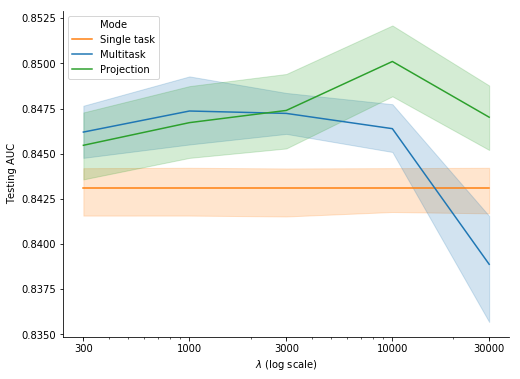

In [0]:
df2 = df.loc[((df['mode'] == 'Single task')
              | (df['mode'] == 'Multitask')
              | ((df['mode'] == 'Projection')
                 & (df['alpha'] == 1)
                 & df['overall'] == True)), :].copy()

chart_celeba(df2[df2['lam'] <= 30000])

In [0]:
a = np.array(df2.loc[(df['mode'] == 'Projection')
                     & (df['lam'] == 10000), 'test_auc'])
b = np.array(df2.loc[(df['mode'] == 'Multitask')
                     & (df['lam'] == 1000), 'test_auc'])
c = np.array(df2.loc[(df['mode'] == 'Single task'), 'test_auc'])

print('Wilcoxon test for Projection (lambda = 10000) and Multitask (lambda = 1000): %.4f'
      % scipy.stats.wilcoxon(a, b[:len(a)]).pvalue)
print('Wilcoxon test for Multitask (lambda = 1000) and Single Task (p-value): %.4f'
      % scipy.stats.wilcoxon(b, c[:len(b)]).pvalue)

Wilcoxon test for Projection (lambda = 10000) and Multitask (lambda = 1000): 0.0051
Wilcoxon test for Multitask (lambda = 1000) and Single Task (p-value): 0.0093


### Comparison with unweighted cosine and weighted cosine

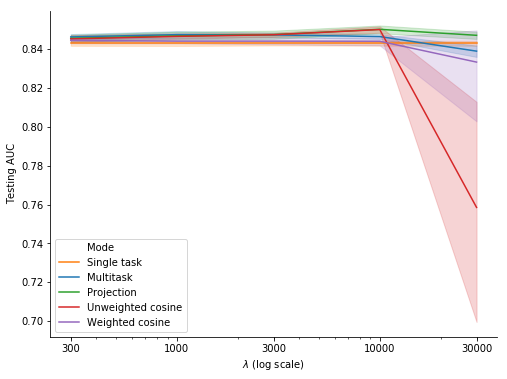

In [0]:
df2 = df.loc[(df['alpha'] == 1) & (df['overall'] == True) & (df['lam'] <= 30000), :].copy()
chart_celeba(df2)

### Effects of using an exponential moving average on $\nabla \mathcal{L}_{\text{primary}}$ for calculating $G_{\text{primary}}$

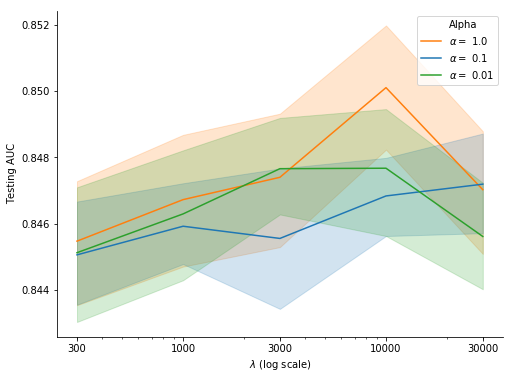

In [0]:
df2 = df.loc[(df['mode'] == 'Projection') & df['overall'], :].copy()
df2['alpha'] = r'$\alpha =$ ' + df2['alpha'].astype(str).copy()
chart_celeba(df2, hue='alpha')

### Projecting at the level of the whole parameter vector, each variable or each parameter?

We could wonder whether the projection should be applied to either the vector including all shared parameters, the vectors corresponding to each of the 10 variables (one weight variable and one bias variable for each shared layer) or even each individual parameter. These options seem all reasonable given that they all satisfy $G_{\text{auxiliary}} . \nabla\mathcal{L}_{\text{primary}} \geq 0$ and $G_{\text{auxiliary}} . 
\nabla\mathcal{L}_{\text{auxiliary}} \geq 0$. The chart below shows similar results for the *overall projection* or the *variable-wise projection* but significantly worse results for the *parameter-wise projection*.

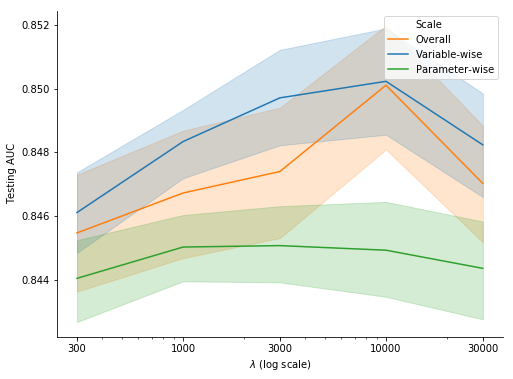

In [0]:
df2 = df.loc[((df['mode'] == 'Projection')
              | (df['mode'] == 'Parameter-wise'))
             & (df['alpha'] == 1), :].copy()

chart_celeba(df2, hue='scale')

# Experiments on the synthetic dataset

In [0]:
df = pd.read_csv('synthetic_dataset_experiments.csv')

### Comparison of single task, multitask and projection

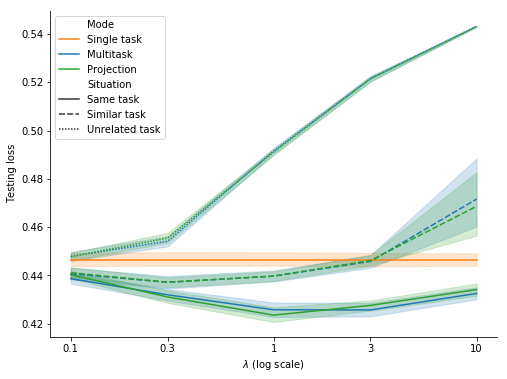

In [0]:
df2 = df[((df['mode'] == 'Single task')
         | (df['mode'] == 'Multitask')
         | ((df['mode'] == 'Projection')
           & (df['overall'] == True)))].copy()

chart_synthetic(df2[df2['alpha'] == 1].copy())

### Comparison of single task, multitask and projection when using an exponential moving average on $\nabla \mathcal{L}_{\text{primary}}$ for calculating $G_{\text{primary}}$

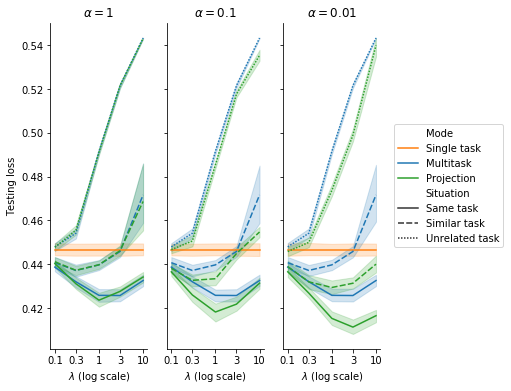

In [0]:
fig, axes = plt.subplots(ncols=4, sharey=True)
df3 = df2[df2['alpha']==1].copy()
chart_synthetic(df3, legend=False, title=r'$\alpha = 1$', ax=axes[0])
df3 = df2[(df2['alpha']==0.1) | (df2['mode'] != 'Projection')].copy()
chart_synthetic(df3, legend=False, title=r'$\alpha = 0.1$', ax=axes[1])
df3 = df2[(df2['alpha']==0.01) | (df2['mode'] != 'Projection')].copy()
chart_synthetic(df3, ax=axes[2])
handles, labels = axes[2].get_legend_handles_labels()
axes[2].clear()
chart_synthetic(df3, legend=False, title=r'$\alpha = 0.01$', ax=axes[2])
axes[3].axis('off')
_ = axes[3].legend(handles, [s.capitalize() for s in labels], loc='center')

### Comparison with unweighted cosine and weighted cosine for $\alpha = 1$

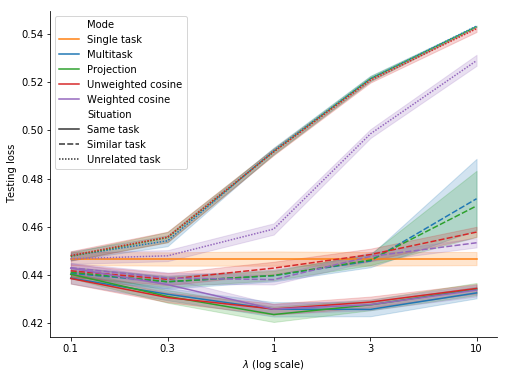

In [0]:
df2 = df[(df['overall'] == True)
         & (df['mode'] != 'Parameter-wise')].copy()

chart_synthetic(df2[(df2['alpha'] == 1)].copy())

### Comparison with unweighted cosine and weighted cosine for $\alpha = 0.1$

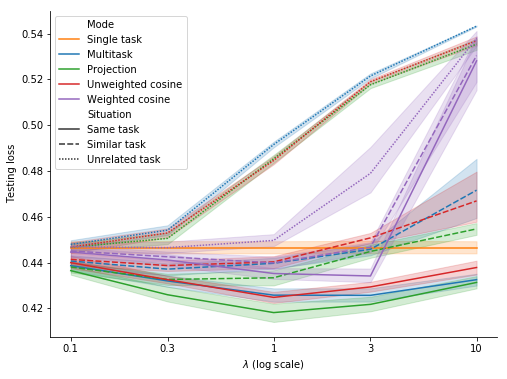

In [0]:
chart_synthetic(df2[(df2['alpha'] == 0.1)
                    | (df2['mode'] == 'Single task')
                    | (df2['mode'] == 'Multitask')].copy())

### Comparison with unweighted cosine and weighted cosine for $\alpha = 0.01$

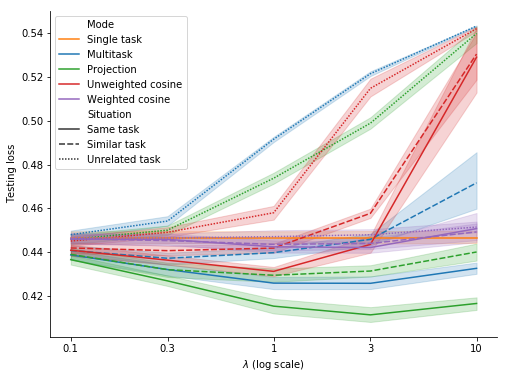

In [0]:
chart_synthetic(df2[(df2['alpha'] == 0.01)
                    | (df2['mode'] == 'Single task')
                    | (df2['mode'] == 'Multitask')].copy())

### Effects of projecting at the level of the whole parameter vector, each variable or each parameter

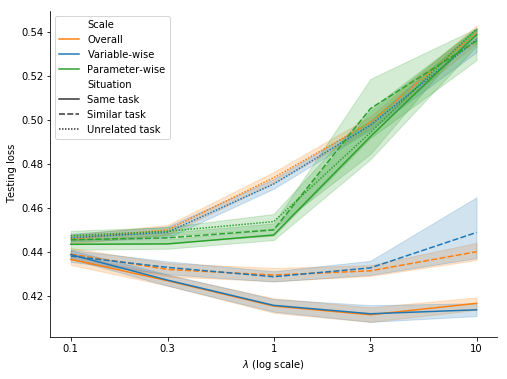

In [0]:
for i in range(len(df)):
  if df.loc[i, 'mode'] == 'Parameter-wise':
    df.loc[i, 'scale'] = 'Parameter-wise'
  else:
    df.loc[i, 'scale'] = 'Overall' if df.loc[i, 'overall'] else 'Variable-wise'

chart_synthetic(df[((df['mode'] == 'Projection') 
                    | (df['mode'] == 'Parameter-wise'))
                   & (df['alpha'] == 0.01)].copy(), hue='scale')